In [ ]:
!pip install hdbscan


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 26.9 MB/s eta 0:00:00


In [4]:
from google.colab import files
uploaded = files.upload()


Saving user_attribures.csv to user_attribures.csv


In [5]:
import pandas as pd

file_path = 'user_attribures.csv'
data = pd.read_csv(file_path)


In [6]:
!pip install hdbscan statsmodels


In [7]:
# Convert date columns to datetime
data['account_creation_date'] = pd.to_datetime(data['account_creation_date'], format='%d-%m-%Y %H:%M', dayfirst=True)
data['last_login_date'] = pd.to_datetime(data['last_login_date'], format='%d-%m-%Y %H:%M', dayfirst=True)

# Clean 'total_spent' column (if necessary)
if data['total_spent'].dtype == 'object':
    data['total_spent'] = data['total_spent'].str.replace(r'[$,]', '', regex=True).astype(float)
else:
    data['total_spent'] = data['total_spent'].astype(float)

# Feature Engineering
data['days_since_creation'] = (pd.Timestamp.now() - data['account_creation_date']).dt.days
features = data[['total_spent', 'transaction_frequency', 'average_transaction_value', 'days_since_creation']]

# Scaling features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


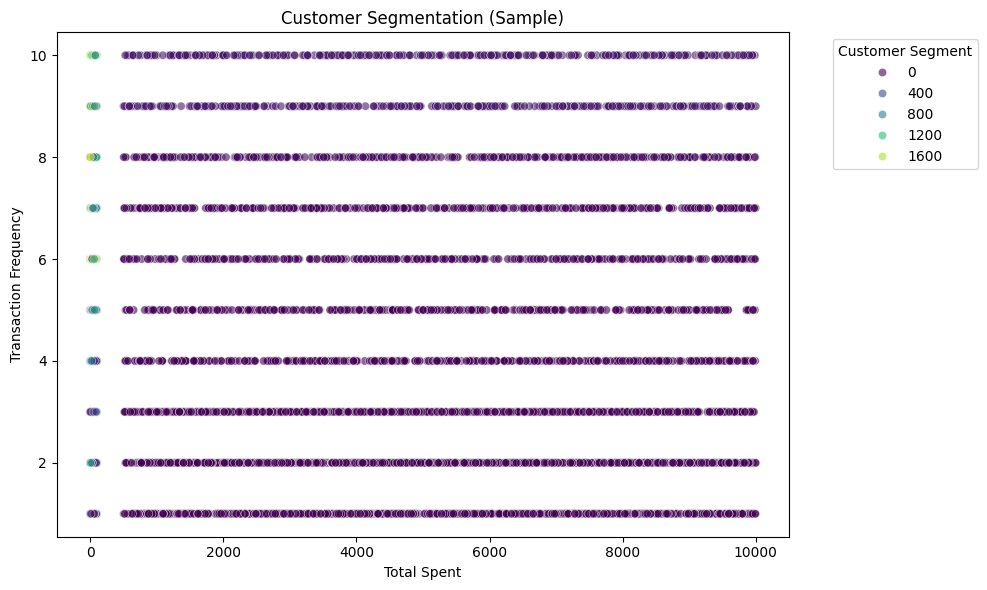

In [8]:
from hdbscan import HDBSCAN

# Customer Segmentation using HDBSCAN
clusterer = HDBSCAN(min_cluster_size=50, min_samples=10, prediction_data=True)
data['customer_segment'] = clusterer.fit_predict(features_scaled)

# Visualize Customer Segments (using a sample for faster plotting)
import seaborn as sns
import matplotlib.pyplot as plt

sample_size = min(10000, len(data))
sample_data = data.sample(n=sample_size, random_state=42)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=sample_data, x='total_spent', y='transaction_frequency', hue='customer_segment', palette='viridis', alpha=0.6)
plt.title('Customer Segmentation (Sample)')
plt.xlabel('Total Spent')
plt.ylabel('Transaction Frequency')
plt.legend(title='Customer Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


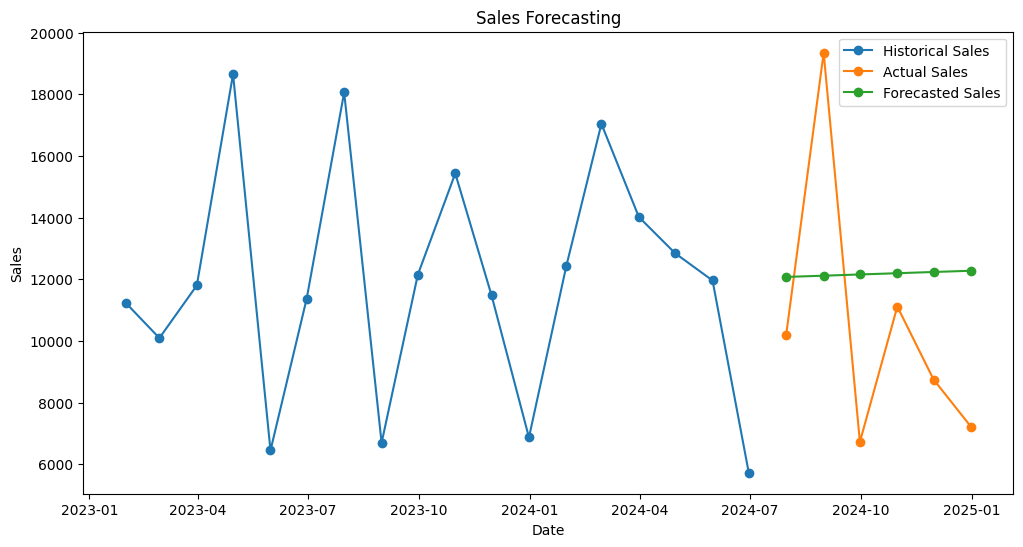

Forecast MAPE: 42.68%


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Create dummy time series data if 'transaction_date' or 'transaction_amount' not available
if 'transaction_date' in data.columns and 'transaction_amount' in data.columns:
    monthly_sales = data.groupby(data['transaction_date'].dt.to_period('M'))['transaction_amount'].sum().reset_index()
    monthly_sales['transaction_date'] = monthly_sales['transaction_date'].dt.to_timestamp()
else:
    # Create dummy time series data
    dates = pd.date_range(start='2023-01-01', periods=24, freq='ME')  # Use 'ME' for month-end frequency
    sales = np.random.randint(5000, 20000, size=(24,))
    monthly_sales = pd.DataFrame({'transaction_date': dates, 'transaction_amount': sales})

# Split data into train and test sets
train_data = monthly_sales.iloc[:-6]
test_data = monthly_sales.iloc[-6:]

# Fit the Exponential Smoothing model
# Change seasonal='add' and seasonal_periods=12 if you have enough data, else set seasonal=None
model = ExponentialSmoothing(train_data['transaction_amount'], trend='add', seasonal=None)  # or seasonal='add', seasonal_periods=6
fit_model = model.fit()

# Forecasting
forecast = fit_model.forecast(steps=6)

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(train_data['transaction_date'], train_data['transaction_amount'], label='Historical Sales', marker='o')
plt.plot(test_data['transaction_date'], test_data['transaction_amount'], label='Actual Sales', marker='o')
plt.plot(test_data['transaction_date'], forecast, label='Forecasted Sales', marker='o')
plt.title('Sales Forecasting')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Calculate MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((test_data['transaction_amount'].values - forecast) / test_data['transaction_amount'].values)) * 100
print(f"Forecast MAPE: {mape:.2f}%")


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

# Create dummy time series data if 'transaction_date' or 'transaction_amount' not available
if 'transaction_date' in data.columns and 'transaction_amount' in data.columns:
    monthly_sales = data.groupby(data['transaction_date'].dt.to_period('M'))['transaction_amount'].sum().reset_index()
    monthly_sales['transaction_date'] = monthly_sales['transaction_date'].dt.to_timestamp()
else:
    # Create dummy time series data
    dates = pd.date_range(start='2023-01-01', periods=24, freq='ME')
    sales = np.random.randint(5000, 20000, size=(24,))
    monthly_sales = pd.DataFrame({'transaction_date': dates, 'transaction_amount': sales})

# Set the date as the index
monthly_sales.set_index('transaction_date', inplace=True)

# Split data into train and test sets
train_data = monthly_sales.iloc[:-6]
test_data = monthly_sales.iloc[-6:]

# Feature engineering: Add month and quarter as features
monthly_sales['month'] = monthly_sales.index.month
monthly_sales['quarter'] = monthly_sales.index.quarter

# Fit the SARIMA model
model = SARIMAX(train_data['transaction_amount'],
                exog=train_data[['month', 'quarter']],
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()

# Forecasting
forecast = results.forecast(steps=6, exog=test_data[['month', 'quarter']])

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['transaction_amount'], label='Historical Sales', marker='o')
plt.plot(test_data.index, test_data['transaction_amount'], label='Actual Sales', marker='o')
plt.plot(test_data.index, forecast, label='Forecasted Sales', marker='o')
plt.title('Improved Sales Forecasting')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Calculate MAPE (Mean Absolute Percentage Error)
mape = mean_absolute_percentage_error(test_data['transaction_amount'], forecast) * 100
print(f"Forecast MAPE: {mape:.2f}%")

# Print model summary for diagnostics
print(results.summary())

KeyError: "None of [Index(['month', 'quarter'], dtype='object')] are in the [columns]"

In [22]:
# Ensure you've run all previous steps before this code

# Save the results to a CSV file
output_file = 'user_attributes_with_segments.csv'  # Filename to save the DataFrame
data.to_csv(output_file, index=False)  # Save the DataFrame to CSV without the index

# Check if the file was saved successfully
import os
if os.path.exists(output_file):
    print(f"File '{output_file}' saved successfully.")
else:
    print(f"Error: File '{output_file}' was not saved.")

# Download the results file
from google.colab import files
files.download(output_file)  # Trigger the file download


File 'user_attributes_with_segments.csv' saved successfully.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>